In [1]:
import pandas as pd
import re
import jieba
from tqdm import tqdm
import torch
from opencc import OpenCC

In [2]:
# 检查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# 读取数据集
data_path = '../datasets/chinese_movie_reviews/chinese_movie_reviews_datasets.jsonl'
df = pd.read_json(data_path, orient='records', lines=True)
print(f'数据数量{len(df)}')
print(df.sample(5))

数据数量508110
                                                  content  stars  label
23638                                         虽然不长 但是真的不错      4      1
477707  本该是三个骗子互相拆台的一出好戏，变成了两个傻子在一个骗子的疯狂摆布下，不得不演上一出“老婆...      2      0
497163      7.0分\n补标\n 个人并不怎么喜欢这个电影，催泪是催泪，但是过度的美化让我觉得很虚假。      3      0
312039  本質上與《密陽》是相似的，只有最虔誠的教徒，才能拍出深刻懷疑宗教本質的作品。當對某種事物信仰...      3      0
262080  喜欢结尾部分，两全其美，孩子快乐，公司也能照常运行，而且大猫咪和小女孩重新见面了。\n大眼仔...      3      0


## 数据预处理

1. 分词
2. 训练Word2Vec：生成一个包含语料库中的每个词的向量空间

In [4]:
# 初始化 OpenCC 转换器（繁转简）
cc = OpenCC('t2s')  # t2s 表示繁体转简体

# 读取停用词表
with open('../datasets/chinese_movie_reviews/stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = [line.strip() for line in f.readlines()]

# 繁体字转简体字
def traditional_to_simplified(text):
    return cc.convert(text)

# 移除数字
def remove_digit(text):
     return re.sub(r'\d+', '', text)

# 分词处理
def tokenize(text):
    return " ".join(jieba.cut(text))

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stopwords])

# 应用预处理
def process_row(text):
    text = remove_digit(text) # 移除数字
    text = traditional_to_simplified(text)  # 繁体字转简体字
    text = re.sub(r"[^\u4e00-\u9fa5]", "", text)  # 只保留汉字字符
    text = tokenize(text)
    text = remove_stopwords(text)
    return text

df["content"] = df["content"].apply(process_row) # 作者在这里大概用了2分钟

# 计算每条文本的长度
sentence_lengths = df["content"].apply(lambda x: len(x.split()))  # 计算每条文本的词数（已经分词）
# 计算最大长度和平均长度
max_length = sentence_lengths.max()
avg_length = sentence_lengths.mean()
print(f"最大文本长度：{max_length}")
print(f"平均文本长度：{avg_length:.2f}")

df.sample(5)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\PC\AppData\Local\Temp\jieba.cache
Loading model cost 0.531 seconds.
Prefix dict has been built successfully.


最大文本长度：625
平均文本长度：21.04


,content,stars,label
249264,亲生女儿 床上 试探 对方 性爱 技术 行不行 老鸨 母亲 男妓 性虐 自己 老婆 还要 旁...,4,1
225658,毕 格罗 真是 美国 主旋律 中 找到 一条 永远 不会错 套路 整体 喜欢 真实感 戏剧化...,4,1
505707,白夜 行 嫌疑人 导演 会 玩,3,0
77225,反正 儿子 喜欢 就行 过年 嘛,4,1
313291,大家 普及 下万 台币 约等于 万 人民币,3,0


#### Word2Vec

`Word2Vec训练很快，一分钟以内就能结束`

In [5]:
import numpy as np
from gensim.models import Word2Vec

def prepare_data(df, vector_size, max_length=100):
    # 将文本转换为词列表
    texts = df['content'].apply(lambda x: x.split())

    # 首先创建一个空的词汇表并添加 <PAD> 词索引为 0
    vocab = {"<PAD>": 0}
    
    # 训练Word2Vec模型
    w2v_model = Word2Vec(sentences=texts, vector_size=vector_size, window=8, min_count=1, workers=4)
    
    # 获取模型训练后生成的词汇表
    vocab.update({k: v+1 for k, v in w2v_model.wv.key_to_index.items()})
    
    # 将文本转换为序列，如果词不在词汇表中，则用0表示
    sequences = [[vocab.get(word, 0) for word in text] for text in texts]

    # 对每个序列进行填充或截断
    padded = [s[:max_length] + [0] * (max_length - len(s)) if len(s) < max_length 
              else s[:max_length] for s in sequences]
    
    embedding_matrix = np.zeros((len(vocab), vector_size))
    for word, i in vocab.items():
        if word != "<PAD>":  # 确保 <PAD> 不会被赋予任何词向量
            embedding_matrix[i] = w2v_model.wv[word]
    
    return np.array(padded), embedding_matrix, vocab

vector_size=64
padded, embedding_matrix, vocab = prepare_data(df, vector_size=vector_size)

In [6]:
# 查看词汇表的前几个词
print(f'词汇表大小： {len(vocab)}')
print("词汇表的一部分:")
for word, idx in list(vocab.items())[:5]:  # 查看前5个词
    print(f"词: {word}, 索引: {idx}")

# 查看嵌入矩阵中对应某个词的词向量
word_to_check = '狗'  
if word_to_check in vocab:
    word_index = vocab[word_to_check]
    word_vector = embedding_matrix[word_index]
    print(f"{word_to_check} 的词向量:")
    print(word_vector)
else:
    print(f"词汇表中没有 {word_to_check} 这个词。")

词汇表大小： 276419
词汇表的一部分:
词: <PAD>, 索引: 0
词: 看, 索引: 1
词: 人, 索引: 2
词: 但, 索引: 3
词: 好, 索引: 4
狗 的词向量:
[ 3.16218114 -6.14741898  0.45720214  1.25703156  0.1533884   1.27312267
 -0.27875459  1.01880586  2.33547425  1.80326021  3.15771031 -2.79145074
  2.76341057 -2.16252637  0.60111237 -1.56099725 -1.9911598   1.41523695
 -0.49740243 -0.77958089 -3.30216146 -0.86797374  1.85962439 -3.29307961
 -0.22757535  0.89264297 -0.23079529  3.71837664  2.57455182  4.17028141
  3.17933297  1.90085232]


#### 构建数据集

In [7]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class TextDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.LongTensor(sequences)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

X = padded
y = df['label'].values
# stratify=df["label"] 使得训练集和测试集中的标签分布是均匀
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=df["label"])  

train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [8]:
# 查看训练集和测试集的大小
print(f"训练集大小: {len(train_dataset)}")
print(f"测试集大小: {len(test_dataset)}")

# 查看训练集和测试集的标签分布
from collections import Counter

train_labels_counter = Counter(y_train)
test_labels_counter = Counter(y_test)
print(f"训练集标签分布: {train_labels_counter}")
print(f"测试集标签分布: {test_labels_counter}")

训练集大小: 457299
测试集大小: 50811
训练集标签分布: Counter({1: 228650, 0: 228649})
测试集标签分布: Counter({0: 25406, 1: 25405})


## 定义模型

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, hidden_dim=64):
        super().__init__()
        # 定义词嵌入层，使用 embedding_matrix 初始化
        self.embedding = nn.Embedding.from_pretrained(
            torch.FloatTensor(embedding_matrix),
            padding_idx=0
        )
        self.embedding.weight.requires_grad = False # True 确保嵌入层的参数可训练
        """
        双向 LSTM 层：输入维度为 embedding_dim，输出维度为 hidden_dim。
        batch_first=True : 输入张量的形状为 (batch_size, sequence_length)。
        bidirectional=True : LSTM 会在两个方向上（正向和反向）处理输入序列，以捕捉更多上下文信息
        (因为 LSTM 是双向的，它的输出将是两个隐藏层的连接, 所以实际输出维度为 hidden_dim * 2)
        """
        self.lstm = nn.LSTM(
            embedding_dim,    # 输入特征的维度
            hidden_dim,       # 隐藏状态的维度
            num_layers=2,     # LSTM的层数
            batch_first=True, # 输入和输出的张量的第一个维度是batch_size
            bidirectional=True, # 使用双向LSTM
            dropout=0.5
        )
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)  # 添加一个额外的全连接层
        self.fc2 = nn.Linear(hidden_dim, 2)  # 二分类任务
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded) # 第二个返回值_是LSTM的隐藏状态和单元状态；lstm_out形状： (batch_size, sequence_length, hidden_dim * 2)
        last_hidden = lstm_out[:, -1, :] # 选择每个批次中的最后一个时刻的输出，形状为 (batch_size, hidden_dim * 2)
        dropped = self.dropout(last_hidden)
        fc1_out = F.relu(self.fc1(dropped))
        fc_out = self.fc2(fc1_out)
        return fc_out


model = TextClassifier(len(vocab) + 1, vector_size, embedding_matrix).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 初始化学习率调度器，每step_size个epoch将学习率衰减为原来的gamma倍
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [10]:
# 查看模型结构
# 打印模型参数总数和可训练参数总数
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())  # 所有参数数量
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)  # 需要训练的参数数量
    print(f"模型总参数数量: {total_params:,}")
    print(f"模型可训练参数数量: {trainable_params:,}")

print(model)
count_parameters(model)

TextClassifier(
  (embedding): Embedding(276419, 32, padding_idx=0)
  (lstm): LSTM(32, 64, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
模型总参数数量: 9,003,298
模型可训练参数数量: 157,890


## 模型训练与评估

In [11]:
from tqdm import tqdm

# 训练函数
def train(dataloader, model, loss_fn, optimizer):
    model.train()  # 设置模型为训练模式
    
    running_loss = 0.0
    correct = 0
    total = 0

    # 使用 tqdm 包裹数据加载器，显示进度条
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for texts, labels in progress_bar:
        # 将数据移动到设备
        texts, labels = texts.to(device), labels.to(device)

        # 前向传播
        outputs = model(texts)
        loss = loss_fn(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  # 更新模型参数

        # 统计指标
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 更新进度条描述
        progress_bar.set_postfix(lr=optimizer.param_groups[0]['lr'], loss=loss.item())
        
    scheduler.step()  # 更新学习率       

    accuracy = 100 * correct / total
    avg_loss = running_loss / len(dataloader)
    return avg_loss, accuracy

In [12]:
# 测试函数
def evaluate(dataloader, model, loss_fn):
    model.eval()  # 设置模型为评估模式
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # 关闭梯度计算
        progress_bar = tqdm(dataloader, desc="Evaluating", leave=False)
        for texts, labels in progress_bar:
            # 将数据移动到设备
            texts, labels = texts.to(device), labels.to(device)

            # 前向传播
            outputs = model(texts)
            loss = loss_fn(outputs, labels)

            # 统计指标
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # 更新进度条描述
            progress_bar.set_postfix(loss=loss.item())

    accuracy = 100 * correct / total
    avg_loss = running_loss / len(dataloader)
    return avg_loss, accuracy

In [13]:
# 开始训练

num_epochs = 10

train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    epoch_train_loss, epoch_train_acc = train(train_loader, model, loss_fn, optimizer)

    # 在测试集上评估
    epoch_test_loss, epoch_test_acc = evaluate(test_loader, model, loss_fn)

    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    # 打印训练和测试结果
    template = ('Epoch:{:2d}, Train_acc:{:.1f}%, Train_loss:{:.3f}, Test_acc:{:.1f}%，Test_loss:{:.3f}')
    print(template.format(epoch+1, epoch_train_acc, epoch_train_loss, epoch_test_acc, epoch_test_loss))

print("训练完成!")

Epoch 1/10


Epoch: 1, Train_acc:57.1%, Train_loss:0.675, Test_acc:64.4%，Test_loss:0.631
Epoch 2/10


Epoch: 2, Train_acc:65.7%, Train_loss:0.613, Test_acc:67.5%，Test_loss:0.592
Epoch 3/10


Epoch: 3, Train_acc:67.5%, Train_loss:0.591, Test_acc:68.0%，Test_loss:0.585
Epoch 4/10


Epoch: 4, Train_acc:68.1%, Train_loss:0.584, Test_acc:67.9%，Test_loss:0.582
Epoch 5/10


Epoch: 5, Train_acc:68.6%, Train_loss:0.576, Test_acc:68.2%，Test_loss:0.582
Epoch 6/10


Epoch: 6, Train_acc:68.9%, Train_loss:0.572, Test_acc:68.4%，Test_loss:0.578
Epoch 7/10


Epoch: 7, Train_acc:69.3%, Train_loss:0.567, Test_acc:68.2%，Test_loss:0.578
Epoch 8/10


Epoch: 8, Train_acc:69.5%, Train_loss:0.565, Test_acc:68.3%，Test_loss:0.579
Epoch 9/10


Epoch: 9, Train_acc:69.7%, Train_loss:0.562, Test_acc:68.2%，Test_loss:0.579
Epoch 10/10


Epoch:10, Train_acc:69.8%, Train_loss:0.561, Test_acc:68.4%，Test_loss:0.579
训练完成!


## 结果可视化

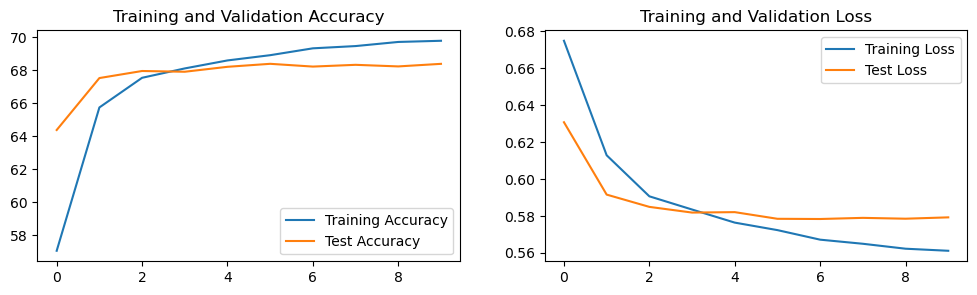

In [14]:
import matplotlib.pyplot as plt

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 模型保存

In [15]:
# 指定保存路径
save_dir = '../models/3_Chinese_Movie_review_Text_Classification'

# 确保目录存在，如果不存在则创建
import os
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 保存模型
torch.save(model.state_dict(), os.path.join(save_dir, 'model_weights.pth'))

# # 加载模型参数
# model.load(torch.load(os.path.join(save_dir, 'model_weights.pth')))